In [1]:
import pandas as pd
import numpy as np
import datetime
import backtrader as bt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 读取全量数据
def read_hq():
    
    stock_daily=pd.read_csv('01_data/trade_list/all9.csv',)

    stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64[ns]")
    stock_daily.set_index("date",inplace=True,drop=False)
    stock_daily["openinterest"]=0
    return stock_daily

In [3]:
# 交易的股票：
share_list=['002304','600111','000858','601318','000568','300033','601601','600436','601628']

In [4]:
#从全量数据中抽取个别股票数据
def get_data_1(syboml,time,stock_d):
    stock=stock_d[stock_d["code"]==int(syboml)][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,time],axis=1).fillna(method="bfill").fillna(method="ffill")
#    stock=pd.concat([stock,time],axis=1).fillna(-1)#对每只股票缺失的交易日进行补齐
    return stock[["open","high","low","close","volume","openinterest"]]

In [5]:
# 获取买卖信号
def get_idx():
    dff = pd.read_csv('03_output/predict/pre 4-4.csv',index_col=0,dtype={'code': 'str'})
    indexlist = dff.index.tolist()
    dict_position = {}
    for x in indexlist:
        # 排序选股
        if(x==indexlist[0]):
            temp = dff.loc[x].sort_values(ascending=False).index.tolist()
            dict_position[x] = temp
        else:
            dict_position[x]=''
    
    return dict_position

In [6]:
def pretty_print(format, *args):
    print(format.format(*args))

def exists(object, *properties):
    for property in properties:
        if not property in object: return False
        object = object.get(property)
    return True

def printTradeAnalysis(cerebro, analyzers):
    format = "  {:<24} : {:<24}"
    NA     = '-'

    print('Backtesting Results')
    if hasattr(analyzers, 'ta'):
        ta = analyzers.ta.get_analysis()

        openTotal         = ta.total.open          if exists(ta, 'total', 'open'  ) else None
        closedTotal       = ta.total.closed        if exists(ta, 'total', 'closed') else None
        wonTotal          = ta.won.total           if exists(ta, 'won',   'total' ) else None
        lostTotal         = ta.lost.total          if exists(ta, 'lost',  'total' ) else None

        streakWonLongest  = ta.streak.won.longest  if exists(ta, 'streak', 'won',  'longest') else None
        streakLostLongest = ta.streak.lost.longest if exists(ta, 'streak', 'lost', 'longest') else None

        pnlNetTotal       = ta.pnl.net.total       if exists(ta, 'pnl', 'net', 'total'  ) else None
        pnlNetAverage     = ta.pnl.net.average     if exists(ta, 'pnl', 'net', 'average') else None

        pretty_print(format, 'Open Positions', openTotal   or NA)
        pretty_print(format, 'Closed Trades',  closedTotal or NA)
        pretty_print(format, 'Winning Trades', wonTotal    or NA)
        pretty_print(format, 'Loosing Trades', lostTotal   or NA)
        print('\n')

        pretty_print(format, 'Longest Winning Streak',   streakWonLongest  or NA)
        pretty_print(format, 'Longest Loosing Streak',   streakLostLongest or NA)
        pretty_print(format, 'Strike Rate (Win/closed)', (wonTotal / closedTotal) * 100 if wonTotal and closedTotal else NA)
        print('\n')

        
        pretty_print(format, 'Net P/L',                '${}'.format(round(pnlNetTotal,   2)) if pnlNetTotal   else NA)
        pretty_print(format, 'P/L Average per trade',  '${}'.format(round(pnlNetAverage, 2)) if pnlNetAverage else NA)
        print('\n')

    if hasattr(analyzers, 'drawdown'):
        pretty_print(format, 'Drawdown', '${}'.format(analyzers.drawdown.get_analysis()['drawdown']))
    if hasattr(analyzers, 'sharpe'):
        pretty_print(format, 'Sharpe Ratio:', analyzers.sharpe.get_analysis()['sharperatio'])
    if hasattr(analyzers, 'vwr'):
        pretty_print(format, 'VRW', analyzers.vwr.get_analysis()['vwr'])
    if hasattr(analyzers, 'sqn'):
        pretty_print(format, 'SQN', analyzers.sqn.get_analysis()['sqn'])
    print('\n')

    print('Transactions')
    format = "  {:<24} {:<24} {:<16} {:<8} {:<8} {:<16}"
    pretty_print(format, 'Date', 'Amount', 'Price', 'SID', 'Symbol', 'Value')
    for key, value in analyzers.txn.get_analysis().items():
        pretty_print(format, key.strftime("%Y/%m/%d %H:%M:%S"), value[0][0], value[0][1], value[0][2], value[0][3], value[0][4])


In [7]:
#定义单个交易日中的策略
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数
    cash_value={}
    params = (
        ("sell_d",{}),("buy_d",{})  # 注意要有逗号！！
    )

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    #单个交易日中的策略：先比较当天是否在买入或者卖出的日期中，如果在就获取日期对应的股票列表进行买卖操作
    def next(self):
        # 检查是否持仓 
        print(str(self.datetime.date(0)))
        self.cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})#记录持仓
        # print(self.params.buy_d.keys())
        if str(self.datetime.date(0)) in self.params.sell_d.keys(): # 卖出目标股票
            s_list=self.params.sell_d[str(self.datetime.date(0))]
            # print(s_list)
            for i in s_list:
                # print(i)
                # print(self.data[i])
                # print(self.datas[i])
                self.order_target_percent(target=0,data=i,exectype=bt.Order.Close)
                
        if str(self.datetime.date(0)) in self.params.buy_d.keys(): # 买入目标股票
            s_list=self.params.buy_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i,exectype=bt.Order.Close)
                

    # 下面两个函数log与notify_order都是为了在交易过程中输出交易记录和其他信息        
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

#读入策略并在所有交易日执行
def huice_run_num(start,end,buy_date,sell_date,stock_daily_x,stock_list,strategy):

    #实例化一个交易程序
    cerebro = bt.Cerebro()

    #把所有涉及到的股票数据塞入交易程序
    time_jy=pd.Series(range(0,len(stock_daily_x.date.unique())),index=stock_daily_x.date.unique()).sort_index()#构建包含所有交易日的序列
    for i in stock_list:#逐个输入涉及到的所有股票数据
        stock=get_data_1(i,time_jy,stock_daily_x)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end,plot=False)           
        cerebro.adddata(data,name=i) 
    
    #交易程序读入对应策略
    cerebro.addstrategy(strategy,sell_d=sell_date,buy_d=buy_date) 
    cerebro.broker.setcash(1000000) #定义初始金额
    cerebro.broker.setcommission(commission=0.0005)#定义佣金


    #下面是数据交易完成后的相关评估参数

    # 定义图表输出哪些观察者observer
    #cerebro.addobserver(bt.observers.Broker)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.Trades)

    #5.添加分析器
    cerebro.addanalyzer(bt.analyzers.AnnualReturn,_name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
    
    # 定义用于策略绩效评价的分析者analyzers，可以随意增加
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.VWR, _name='vwr')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.Transactions, _name='txn')
    
    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    # cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')#获得夏普率
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')#获得回撤
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())

    # 输出分析者结果
    backtest_results = results[0]
    printTradeAnalysis(results, backtest_results.analyzers)
    return (cerebro,results)
    # %matplotlib inline
    # fig = cerebro.plot(style='candlestick')
    # show = fig[0][0]
    # show.set_size_inches(10,5)#调整大小
    # show
    
    #return strategy.cash_value #这是累计收益数据，如果需要自己作图可以用这个
    

2023-06-01 2024-05-29
初始资金: 1000000.00
2023-06-01
2023-06-02, 买入601318, 成交量2221，成交价46.67
2023-06-02, 买入601601, 成交量3679，成交价27.53
2023-06-02, 买入000858, 成交量626，成交价164.12
2023-06-02, 买入601628, 成交量2680，成交价37.91
2023-06-02, 买入300033, 成交量574，成交价171.65
2023-06-02, 买入600111, 成交量4201，成交价24.11
2023-06-02, 买入002304, 成交量765，成交价134.15
2023-06-02, 买入000568, 成交量491，成交价208.00
2023-06-02, 买入600436, 成交量336，成交价300.83
2023-06-02
2023-06-05
2023-06-06
2023-06-07
2023-06-08
2023-06-09
2023-06-12
2023-06-13
2023-06-14
2023-06-15
2023-06-16
2023-06-19
2023-06-20
2023-06-21
2023-06-26
2023-06-27
2023-06-28
2023-06-29
2023-06-30
2023-07-03
2023-07-04
2023-07-05
2023-07-06
2023-07-07
2023-07-10
2023-07-11
2023-07-12
2023-07-13
2023-07-14
2023-07-17
2023-07-18
2023-07-19
2023-07-20
2023-07-21
2023-07-24
2023-07-25
2023-07-26
2023-07-27
2023-07-28
2023-07-31
2023-08-01
2023-08-02
2023-08-03
2023-08-04
2023-08-07
2023-08-08
2023-08-09
2023-08-10
2023-08-11
2023-08-14
2023-08-15
2023-08-16
2023-08-17
2023-08-18
2023-

<IPython.core.display.Javascript object>

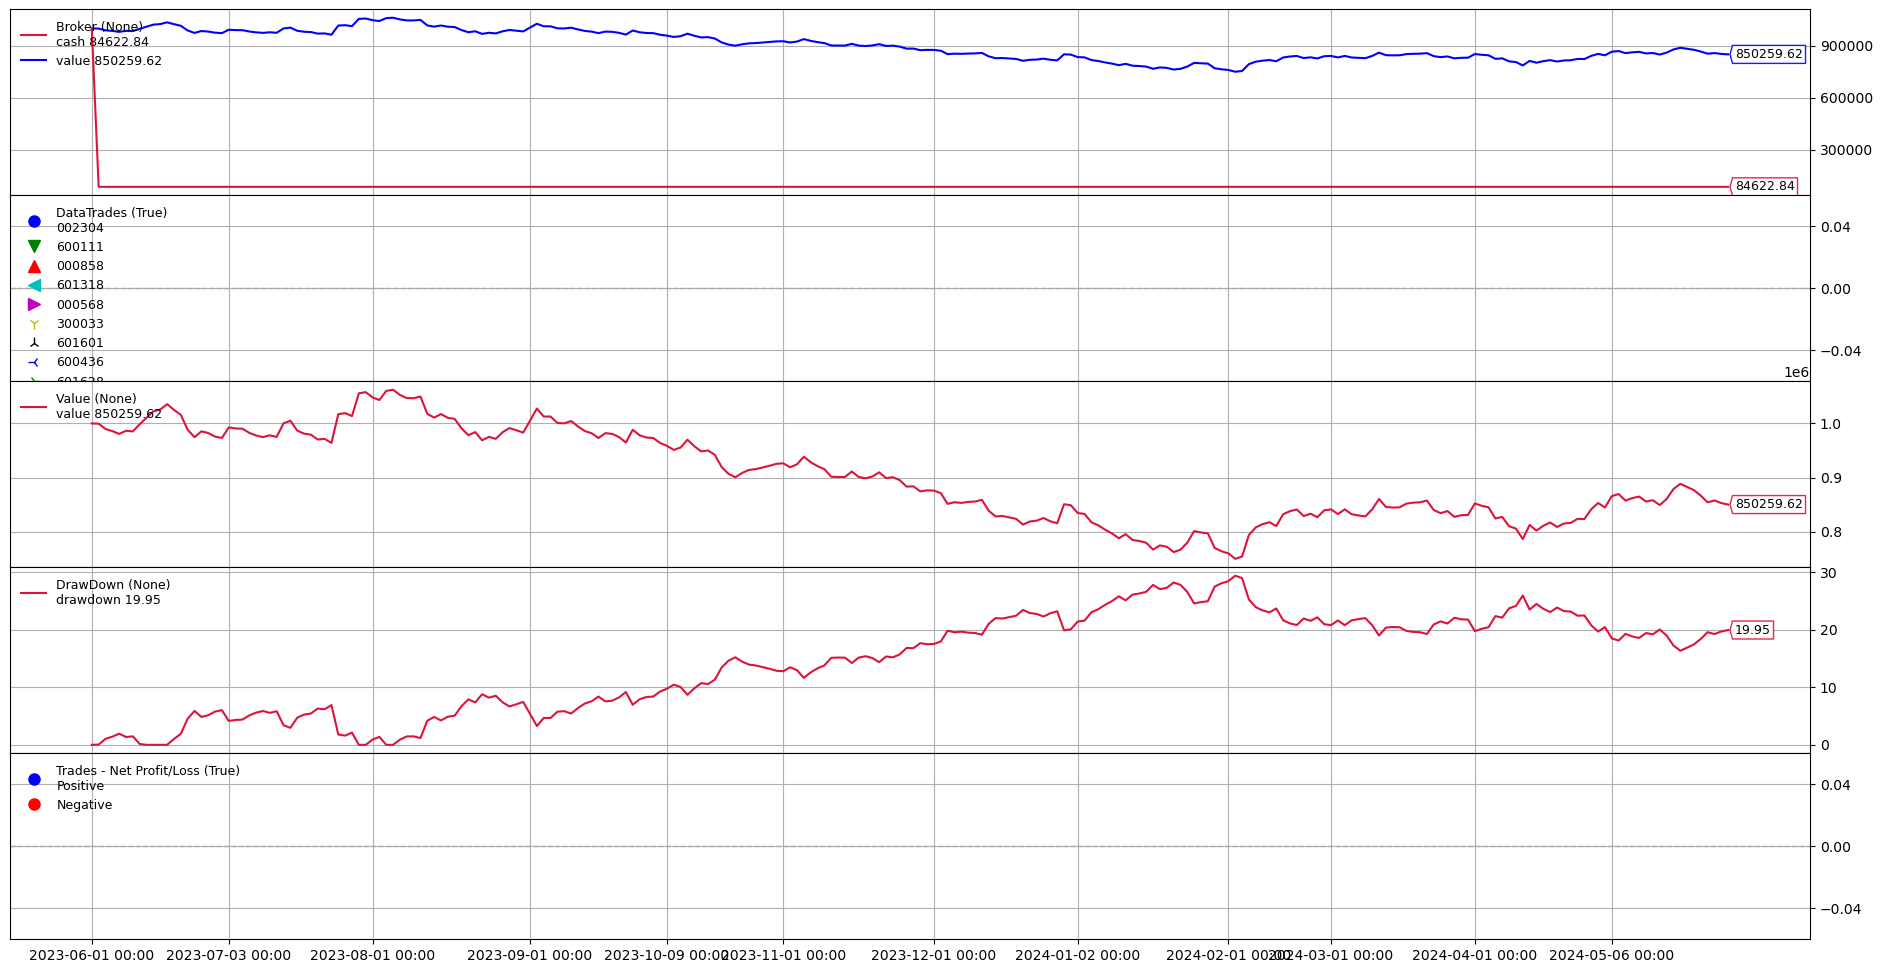

In [8]:
buy_date=get_idx()
buy_date_key=list(buy_date.keys())
buy_date_key.remove(buy_date_key[0])
buy_date_values=list(buy_date.values())
buy_date_values.remove(buy_date_values[-1])
# sell_date=dict(zip(buy_date_key,buy_date_values))
sell_date=dict(zip(buy_date_key,''))
start=datetime.datetime(2023,6,1)
end=datetime.datetime(2024,5,29)
stock_list=share_list
stock_daily=read_hq()
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
cerebro,results=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)
        #7.回测指标结果
st0 = results[0]
Annual_Return = st0.analyzers.AnnualReturn.get_analysis()
sharpe_ratio = st0.analyzers.SharpeRatio.get_analysis()
DrawDown = st0.analyzers.getbyname('DW')
print("Annual_Return: ")
print(Annual_Return)
%matplotlib inline
fig = cerebro.plot(dpi=300,style='candlestick')
show = fig[0][0]
show.set_size_inches(20,10)#调整大小
show.savefig('03_output/backtrade/baseline.png')
show